In [26]:
import torch
import torch.nn.functional as F
import os
from model import HRSeg
import cv2
from dataloader import TestDatasets
import itertools
from utils import TEST_ROOT, RESULT_ROOT, DS_NAMES
import matplotlib.pyplot as plt
from lib.pvt import ChannelAttention, SpatialAttention

In [27]:
TEST_SIZE = 576
PTH_PATH = './model_pth/HRSeg2.e_40.Feb01-04h41.pth'

model = HRSeg().cuda()
model.load_state_dict(torch.load(PTH_PATH, map_location='cuda'))
model.eval()

test_loader = TestDatasets(TEST_ROOT, TEST_SIZE)

Loaded state dict for encoder: pretrained_pth/mit_b2.pth


In [28]:
print(DS_NAMES)

['CVC-300', 'CVC-ClinicDB', 'Kvasir', 'CVC-ColonDB', 'ETIS-LaribPolypDB']


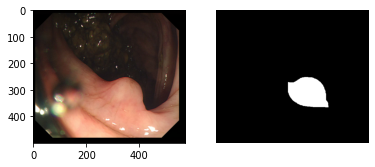

In [38]:
original_image, transformed_image, gt = test_loader.get_item('CVC-ColonDB', 60)
plt.subplot(121), plt.imshow(original_image)
plt.subplot(122), plt.imshow(gt, cmap='gray')
plt.axis('off')
plt.show()

In [39]:
image = transformed_image.unsqueeze(0).cuda()

In [40]:
# Infer outer
outer = F.interpolate(image, size=(288, 288), mode='bilinear')

with torch.no_grad():
    x1, x2, x3, x4 = model.encoder(outer)
    outer_output = model.segm_head([x1, x2, x3, x4])
    weight_map = model.att_head(x1, x2, x3, x4)
outer_output = F.interpolate(outer_output, size=(576, 576), mode='bilinear')
weight_map = F.interpolate(weight_map, size=(576, 576), mode='bilinear')

# Overlapping window infer inner
inner_images = []
for x_min, y_min in itertools.product([0, 144, 288], [0, 144, 288]):
    x_max = x_min + 288
    y_max = y_min + 288
    inner_image = image[:,:,y_min:y_max, x_min:x_max]
    inner_images.append(inner_image[0])
inner_images = torch.stack(inner_images)
with torch.no_grad():
    x1, x2, x3, x4 = model.encoder(inner_images)
    inner_outputs = model.segm_head([x1, x2, x3, x4])

## Fuse
# Sum
combined_inners = torch.zeros(1, 576, 576).cuda()
avg_weight = torch.zeros(1, 576, 576).cuda()
for i, (x_min, y_min) in enumerate(list(itertools.product([0, 144, 288], [0, 144, 288]))):
    x_max = x_min + 288
    y_max = y_min + 288
    combined_inners[:, y_min:y_max, x_min:x_max] += inner_outputs[i]
    avg_weight[:, y_min:y_max, x_min:x_max] += 1
# Average
combined_inners = combined_inners / avg_weight
# Weighted sum
fused_output = combined_inners * weight_map + outer_output * (1-weight_map)

In [41]:
def visualize(tensor, name):
    tensor = torch.squeeze(tensor).cpu().numpy()
    print("min=",tensor.min(), "max=", tensor.max())
    plt.imshow(tensor, cmap='gray')
    plt.title(name)

min= -12.10149 max= 12.556477
min= 0.16931418 max= 0.888252
min= -9.065091 max= 7.644021
min= -9.776579 max= 10.586555


(<AxesSubplot:title={'center':'fused_output'}>, None)

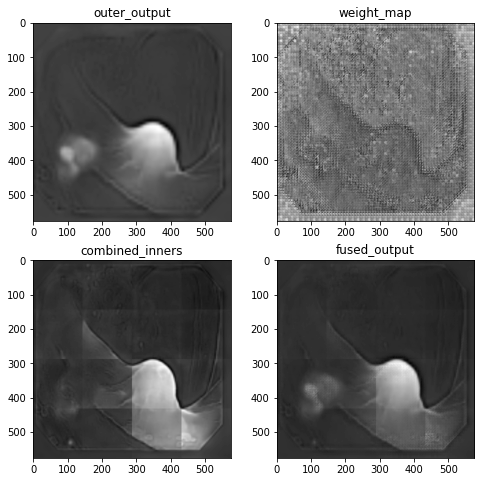

In [42]:
plt.figure(figsize=(8, 8))
plt.subplot(221), visualize(outer_output, "outer_output")
plt.subplot(222), visualize(weight_map, "weight_map")
plt.subplot(223), visualize(combined_inners, "combined_inners")
plt.subplot(224), visualize(fused_output, "fused_output")